# Overview

In the lecture, we saw how we can use regression to predict brain activity of a withheld dataset. We learned to split the data into two distinct sets: a training and a testing dataset.

- **Training dataset**: This is the part of the dataset you use to estimate your model. You can use this data as you wish. Due to **overfitting** you might want to be careful with how much of the variance of this data you want your model to predict.

- **Test dataset**: This dataset should remain untouched until the very end of your analysis, where you only use it to report your results. You should never go back to your analysis and change any parameters based on the performance of your model on the test set.

We selected **two** of the **three** functional localizer runs as our **training dataset** and one separate run as our **testing dataset**. We did the following steps,

- estimated **model weights** ($W$) using *ordinary least squares* (`OLS` function) and the training dataset,
- used these estimated model weights to **predict** the withheld testing dataset ($\hat{Y}_{test}$)
- computed **model performance** (the correlatin between the predicted ($\hat{Y}_{test}$ and actual fMRI data $Y_{test}$) as a measure of regression model performance
- visualized the model performance (i.e, correlation coefficients) on the cortical surface to see which parts of the brain are well predicted by our model.

In this homework, we will use this predictive modeling approach. The predictions on one withheld dataset (the testing run) can sometimes be noisy as well. Hence, here we want to extend the prediction procedure that we learned in the lecture. The method we will implement in this lab is called **cross validation**. This method helps us to have a more reliable understanding of how well our model predicts the fMRI data than only using a fixed testing run.

In [1]:
# Imports
import neurods
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel
import cortex
# Configure defaults for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline
from scipy.stats import zscore

In [2]:
# Some functions that we defined in the past weeks
from numpy.linalg import inv
def OLS(X, Y):
    return np.dot(inv(np.dot(X.T, X)), np.dot(X.T, Y))

def randomize_OLS(X, Y):
    n = X.shape[0]
    sample_index = np.random.choice(n,n)
    return OLS(X[sample_index], Y[sample_index])

def randomize_OLS_for_fMRI(X, Y):
    n = X.shape[0]
    n_blocks = int(n/5)
    block_index = np.arange(n).reshape([n_blocks, -1])
    sample_index = np.random.choice(n_blocks, n_blocks)
    sample_index = block_index[sample_index].reshape([-1])
    return OLS(X[sample_index], Y[sample_index])

def compute_correlation(matrix_1, matrix_2):
    matrix_1_norm  = zscore(matrix_1)
    matrix_2_norm  = zscore(matrix_2)
    corr = np.mean(matrix_1_norm*matrix_2_norm, axis=0)
    return corr

# Setup data

In [3]:
# Load functional localizer information
basedir = os.path.join(neurods.io.data_list['fmri'],'categories')

# Pycortex plotting information
sub, xfm = 's01', 'catloc'
cortical_voxels = cortex.db.get_mask(sub, xfm, type='cortical')

# Load MRI data files
fmri_files = ['s01_categories_{:02d}.nii.gz'.format(run) for run in [1, 2, 3]]
fmri_files = [os.path.join(basedir, f) for f in fmri_files]
print('FMRI files:')
print(fmri_files)
print('\n')

Y = [neurods.io.load_fmri_data(fmri_files[i], mask=cortical_voxels,
                              do_zscore=True, dtype=np.float32)
              for i in [0, 1, 2]]
print('Voxel responses shape: {}'.format(len(Y)))

# Design matrix
design = np.load(os.path.join(basedir,'experiment_design.npz'))
print('Experiment design variables: ', design.keys())
print('\n')
conditions = design['conditions'].tolist()
print('Conditions: ', conditions)

X = [design[run] for run in ['run1', 'run2', 'run3']]
print('Stimuli matrix (design matrix) shape: {}'.format(len(X)))

FMRI files:
['/data/shared/cogneuro88/fMRI/categories/s01_categories_01.nii.gz', '/data/shared/cogneuro88/fMRI/categories/s01_categories_02.nii.gz', '/data/shared/cogneuro88/fMRI/categories/s01_categories_03.nii.gz']


Loading /data/shared/cogneuro88/fMRI/categories/s01_categories_01.nii.gz...
Loading /data/shared/cogneuro88/fMRI/categories/s01_categories_02.nii.gz...
Loading /data/shared/cogneuro88/fMRI/categories/s01_categories_03.nii.gz...
Voxel responses shape: 3
Experiment design variables:  ['run2', 'run3', 'conditions', 'run1']


Conditions:  ['body', 'faces', 'object', 'places', 'scrambled']
Stimuli matrix (design matrix) shape: 3


In [4]:
# Check the shapes of the fMRI and stimuli data
print([y.shape for y in Y])
print([x.shape for x in X])

[(120, 38543), (120, 38543), (120, 38543)]
[(120, 5), (120, 5), (120, 5)]


### [10 points] 1. Implement cross validation

#### (a) [6 points]  We would like you to iterate through the number of runs. At each iteration: 
 - Leave one fMRI run (and the corresponding run in the design matrix) as the testing dataset. 
 - Estimate the regression model weights on the other runs (the training runs).
 - Use these weights to predict fMRI activity for the withheld testing run.
 - Compute the model performance.
 - Save the model_performance.

**HINTs:**
 - Use the np.vstack function (as we did in the lecture) to stack more than one run together for training.
 - Remember to convolve the design matrix with the HRF to account for the hemodynamic response delay.
 - You probably use the similar plots (to plot the training and testing datasets) and check the sizes of your matrices as in the lecture to make sure that you split your data correctly. 

In [5]:
### STUDENT ANSWER
def prediction_CV(Y, X):
    
    """
    Parameters
    ---------
    Y : A list of fMRI data. Each list entry is an fMRI run.
    X : A list of stimulus data (design matrix). Each list entry is a stimulus run.
  
    Returns
    -------
    cv_model_performance : Correlation coefficients for each cross validation step and voxel. 
                         This should be a list with each list element having number of voxels.
    """
    
    cv_model_performance = []
    for run in np.arange(len(Y)):

        print('Cross-validation: {}/{}'.format(run+1, len(np.arange(len(Y)))))

        # Split data into training and testing
        X_train = np.vstack([x for ii, x in enumerate(X) if run != ii])
        X_test = np.vstack([x for ii, x in enumerate(X) if run == ii])

        Y_train = np.vstack([y for ii, y in enumerate(Y) if run != ii])
        Y_test = np.vstack([y for ii, y in enumerate(Y) if run == ii])

        # Check if you got the split correct
        print('Training data size: {}'.format(X_train.shape) )
        print('Testing data size: {}'.format(X_test.shape))

        # Convolve design matrix with HRF (as in Lecture08-Lecture11)
        from neurods.fmri import hrf as generate_hrf
        t_hrf, hrf_1 = generate_hrf(tr=2)
        n_train, d_train = X_train.shape
        n_test, d_test = X_test.shape

        conv_X_train = np.zeros_like(X_train)
        conv_X_test = np.zeros_like(X_test)

        for i in range(d_train):
            conv_X_train[:, i] = np.convolve(X_train[:, i], hrf_1)[:n_train]
        for i in range(d_test):
            conv_X_test[:, i] = np.convolve(X_test[:, i], hrf_1)[:n_test]

        print('Convolved stimuli matrix (design matrix) shape, training: {}'.format(conv_X_train.shape))
        print('Convolved stimuli matrix (design matrix) shape, testing: {}'.format(conv_X_test.shape))

        # Estimate model weights
        weights = OLS(conv_X_train, Y_train)

        # Predict testing data
        Y_hat_test = np.dot(conv_X_test, weights)

        # Model performance: The correlation between real and predicted fMRI data (for testing)
        corr = compute_correlation(Y_test, Y_hat_test)

        # Store
        cv_model_performance.append(corr)

    return cv_model_performance

#### (b) [2 points] Once you have a functioning implementation, convert this into a function. The docstring of this function should look like below:

```
def prediction_CV(Y, X):
  """
  Parameters
  ---------
  Y : A list of fMRI data. Each list entry is an fMRI run.
  X : A list of stimulus data (design matrix). Each list entry is a stimulus run.
  
  Returns
  -------
  cv_model_performance : Correlation coefficients for each cross validation step and voxel. 
                         This should be a list with each list element having number of voxels.
  
  """
```

Use this function to run your cross validation results and visualize the model performance.

In [6]:
### STUDENT ANSWER
cv_model_performance = prediction_CV(Y, X)
print([mp.shape for mp in cv_model_performance])

Cross-validation: 1/3
Training data size: (240, 5)
Testing data size: (120, 5)
Convolved stimuli matrix (design matrix) shape, training: (240, 5)
Convolved stimuli matrix (design matrix) shape, testing: (120, 5)
Cross-validation: 2/3
Training data size: (240, 5)
Testing data size: (120, 5)
Convolved stimuli matrix (design matrix) shape, training: (240, 5)
Convolved stimuli matrix (design matrix) shape, testing: (120, 5)
Cross-validation: 3/3
Training data size: (240, 5)
Testing data size: (120, 5)
Convolved stimuli matrix (design matrix) shape, training: (240, 5)
Convolved stimuli matrix (design matrix) shape, testing: (120, 5)
[(38543,), (38543,), (38543,)]


#### (c) [2 points] Plot the average model performance values onto the cortical flatmap. What can you conclude?
 - c1. Plot first the model performance map from each cross validation step separately. Describe what you notice when you compare these different maps.
 - c2. Plot the average of the three cross validation steps. Describe what you notice when you compare this map to the previous maps.

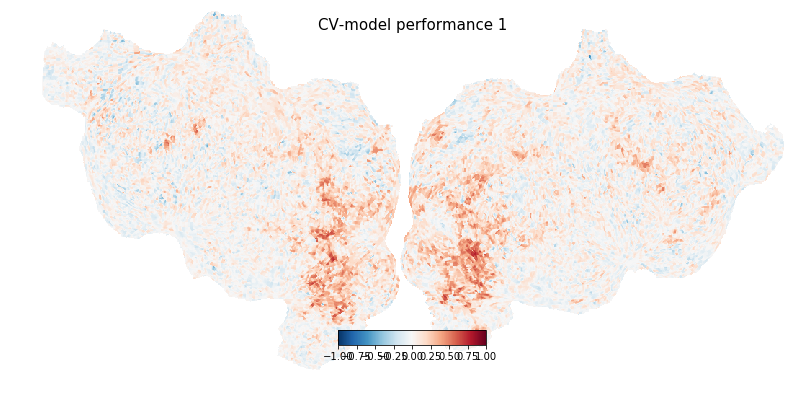

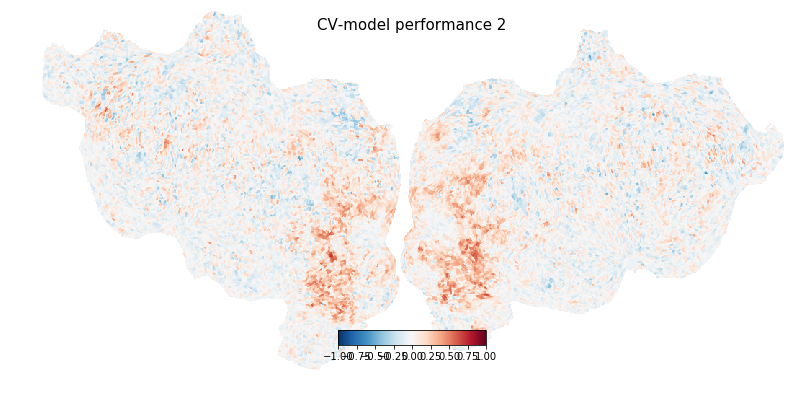

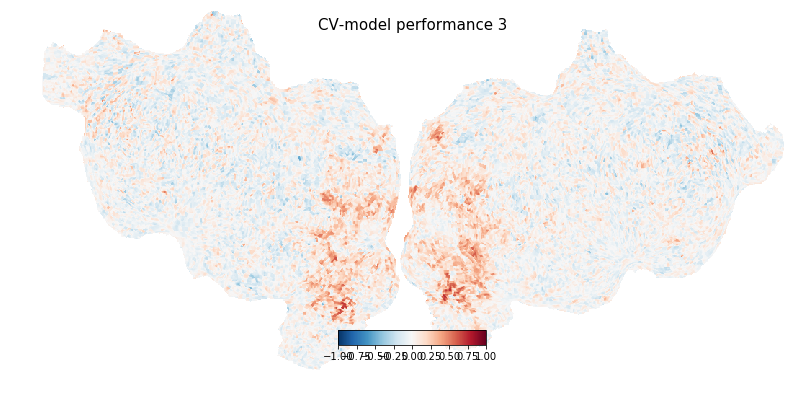

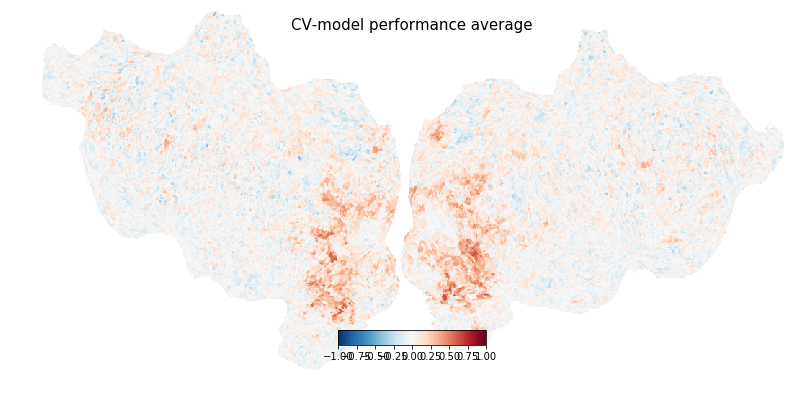

In [7]:
### STUDENT ANSWER
for ii, cv_mp in enumerate(cv_model_performance):
    vol = cortex.Volume(cv_mp, sub, xfm, mask = cortical_voxels,vmin = -1, vmax = 1)
    __  = cortex.quickflat.make_figure(vol)
    plt.suptitle('CV-model performance {}'.format(ii+1), fontsize = 15)
    
vol = cortex.Volume(np.nanmean(cv_model_performance, axis=0), sub, xfm, mask = cortical_voxels,vmin = -1, vmax = 1)
__  = cortex.quickflat.make_figure(vol)
plt.suptitle('CV-model performance average', fontsize = 15)

#### c1
At each cross validation step the early visual cortex and some object related areas have high correlations between the predicted and actual recorded brain data. The first cross validation step predictions are a little noisier than the other two and the average. In general, each cross validation step is providing a slightly different model performance due to noise in our data. This means selecting a specific run as the test run is not necessarily the best choice given noise in model predictions.

#### c2.
The average model performance cleans up the noise. We clearly see that the early visual cortex and few object related areas have reliable model performance. Our model predicts well in these areas.